# Neural Networks

Joaquin Vanschoren, Eindhoven University of Technology

In [12]:
# Global imports and settings
from preamble import *
import keras
print("Using Keras",keras.__version__)
%matplotlib inline
plt.rcParams['figure.dpi'] = 125 # Use 300 for PDF, 100 for slides
# InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

Using Keras 2.1.5


In [13]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Mathematical Foundations
* A first example
* Tensors and tensor operations
* Backpropagation and gradient descent

### A first example: classifying digits
- This example is meant to introduce the main concepts. We'll cover them in more detail later.
- MNIST dataset contains 28x28 pixel images of handwritten digits (0-9)
- The goal is to classify each image as one of the possible digits
- We __reshape__ the data to a 70000x28x28 __tensor__ (n-dimensional matrix)  
    `X = X.reshape(70000, 28, 28)`
- Traditional holdout uses the last 10,000 images for testing

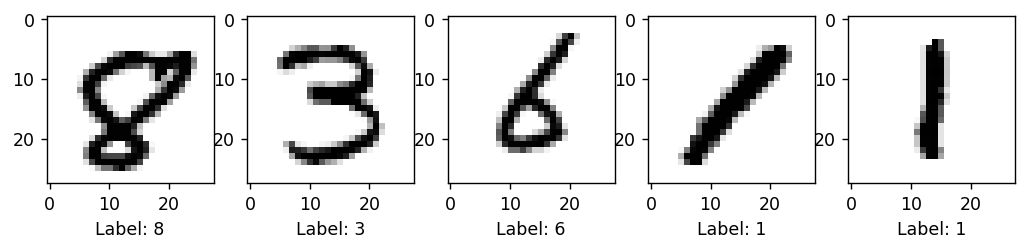

In [14]:
# Download MINST data. Takes a while the first time.
mnist = oml.datasets.get_dataset(554)
X, y = mnist.get_data(target=mnist.default_target_attribute);
X = X.reshape(70000, 28, 28)

# Take some random examples
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,70000)
    axes[i].imshow(X[n], cmap=plt.cm.gray_r)
    axes[i].set_xlabel("Label: {}".format(y[n]))
plt.show();

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=60000)
print("Training set: ",X_train.shape)
print("Test set: ",X_test.shape)

Training set:  (60000, 28, 28)
Test set:  (10000, 28, 28)


Note: this is also one of the datasets that comes included with Keras:
``` python
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
```

#### Neural networks
* The core building block of a neural network is the _layer_
* You can think of it as a _filter_ for the data
    - Data goes in, and comes out in a more useful form
* Layers extract new _representations_ of the data
* _Deep learning_ models contain many such layers
    - They progressively _distill_ (refine) the data
<img src="../images/00_layers.png" alt="ml" style="width: 500px;"/>

* The pixel values are fed to individual _nodes_ of the _input layer_ (yellow)
* The data then passes through one or more _hidden layers_ (blue)
    - One type of layer is the _dense_ or _fully connected_ layer
    - Every node is connected to all nodes in the previous and subsequent layers
* The _output layer_ has a node for every possible outcome (digits 0-9) (red)
    - I.e. The first node returns the probability that the input image represents a '0'
<img src="../images/08_nn_manylayers.png" alt="ml" style="width: 500px;"/>

#### The perceptron
* In its simplest form, each node outputs a weighted sum of the inputs: $y = \sum_{i} x_{i}w_i + b$
* It needs to learn the optimal set of weights to produce the right output
    * _Bias_ $b$: modelled as the weight of an extra input that's always '1'
* This is the same as a linear model, can only learn linear decision boundaries.
    * Even a deep neural net of perceptrons can only learn a linear model
<img src="../images/08_log_reg_nn.png" alt="ml" style="width: 300px;"/>


#### Activation functions
* To learn a non-linear model, each hidden node has to output a non-linear _activation function_ $f$ on the weighted sum of the inputs: $h(x)=f(W_1 x+b_1)$
* Likewise, the output nodes use an activation function $g$ on the weighted outputs of the previous layer: $o(x)=g(W_2 h(x)+b_2)$
<img src="../images/08_nn_basic_arch.png" alt="ml" style="width: 400px;"/>

#### Activation functions
* For hidden nodes, popular choices are the _rectified linear unit_ (ReLU) and _tanh_
    - There are many others. We'll come back to this soon!
    - ReLU is very cheap to compute, speeds up training
* For classification, we use _softmax_ (or sigmoid)
    - Transforms the input into a probability for (each specific outcome)
    - This is exactly what we used for logistic regression!
<img src="../images/08_activation.png" alt="ml" style="width: 1000px;"/>

We can now build a simple neural network for MNIST:
* One dense hidden ReLU layer with 512 nodes
    - Input from a 28x28 matrix
* Output softmax layer with 10 nodes

``` python
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

```

In [16]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

'Visualize' the model using `summary()` 
- Also shows the number of model parameters (weights) that need to be learned

In [17]:
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


#### Compilation
We still need to specify how we want the network to be trained:
* __Loss function__: The objective function used to measure how well the model is doing, and steer itself in the right direction
    - e.g. Cross Entropy (_negative log likelihood_ or _log loss_) for classification
* __Optimizer__: How to optimize the model weights in every iteration.
    - usually a [variant of stochastic gradient descent](http://ruder.io/optimizing-gradient-descent/index.html#momentum)
* __Metrics__ to monitor performance during training and testing.
    - e.g. accuracy
    
``` python
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
```

In [18]:
network.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#### Preprocessing 
* Neural networks are sensitive to scaling, so always scale the inputs
* The network expects the data in shape (n, 28 * 28), so we also need to reshape
* We also need to categorically encode the labels
    - e.g. '4' becomes [0,0,0,0,1,0,0,0,0,0]

``` python
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
```

In [19]:
X_train = X_train.reshape((60000, 28 * 28))
X_test = X_test.reshape((10000, 28 * 28))

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#### Training
Training (fitting) is done by __stochastic gradient descent__ (SGD).
* Optimizes the model parameters (weights)
* We'll come back to this soon

In [24]:
network.fit(X_train, y_train, epochs=5, batch_size=128);

Epoch 1/5
60000/60000 [==============================] - 4s 74us/step - loss: 0.0281 - acc: 0.9916
Epoch 2/5
60000/60000 [==============================] - 4s 63us/step - loss: 0.0208 - acc: 0.9939
Epoch 3/5
60000/60000 [==============================] - 4s 63us/step - loss: 0.0156 - acc: 0.9955
Epoch 4/5
60000/60000 [==============================] - 4s 63us/step - loss: 0.0121 - acc: 0.9965
Epoch 5/5
60000/60000 [==============================] - 4s 63us/step - loss: 0.0098 - acc: 0.9972


#### Prediction
We can now call `predict` or `predict_proba` to generate predictions

``` python
np.set_printoptions(precision=7)
print("Prediction: ",network.predict(X_test)[0])
```

In [21]:
np.set_printoptions(precision=7)
print("Prediction: ",network.predict(X_test)[0])
print("Label: ",y_test[0])

Prediction:  [0.        0.0000002 0.        0.000001  0.9863701 0.000019  0.
 0.0000008 0.0005651 0.0130437]
Label:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


#### Evaluation
Evaluate the trained model on the entire test set

``` python
test_loss, test_acc = network.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)
```

In [22]:
test_loss, test_acc = network.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

10000/10000 [==============================] - 1s 57us/step
Test accuracy: 0.9793


#### Overfitting
* Our test set accuracy is quite a bit lower than our training set accuracy
* We've already seen many choices (moving pieces) that can still be optimized:
    - Number of layers
    - Number of nodes per layer
    - Activation functions
    - Loss function (and hyperparameters)
    - SGD optimizer (and hyperparameters)
    - Batch size
    - Number of epochs

### Tensors and tensor operations
Representing data and learning better representations

#### Tensors
* A _tensor_ is simply an n-dimensional array (with n axes)
    * 2D tensor: matrix (samples, features)
    * 3D tensor: grayscale images (samples, height, width)
        - or time series (samples, timesteps, features)
    * 4D tensor: color images (samples, height, width, channels)
    * 5D tensor: video (amples, frames, height, width, channels)  
    
<img src="../images/08_timeseries.png" alt="ml" style="float: left; width: 30%;"/>
<img src="../images/08_images.png" alt="ml" style="float: left; width: 30%;"/>

#### Tensor operations
The operations that neural network layers perform on the data can be reduced to a handful of tensor operations.

``` python
keras.layers.Dense(512, activation='relu') 
```

can be interpreted as a function

``` python
y = relu(dot(W, x) + b)
```

* takes a 2D tensor $x$ and returns a new 2D tensor $y$
* uses a 2D weight tensor $W$ and a bias vector $b$
* performs a dot product, addition, and $relu(x) = max(x,0)$

#### Element-wise operations

ReLU and addition are element-wise operations. Since numpy arrays support element-wise operations natively, these are simply:

``` python
def relu(x):
  return np.maximum(x, 0.)

def add(x, y):
  return x + y
```

Note: if y has a lower dimension than x, it will be _broadcasted_: axes are added to match the dimensionality, and y is repeated along the new axes 

``` python
>>> np.array([[1,2],[3,4]]) + np.array([10,20])
array([[11, 22],
       [13, 24]])
```

#### Tensor dot
The dot product $x . y$ of two tensors can also be done easily with numpy:
``` python 
z = np.dot(x, y)
```
where 
``` python 
z[i,j] = x[i,:] * y[:,j]
```

<img src="../images/08_dot.png" alt="ml" style="float: left; width: 30%;"/>


#### Geometric interpretation
* Dot products and additions change how data points relate to each other
* We aim to find a transformation of the data points so that it becomes easy to:
    - separate the classes (classification)
    - learn a simple function (regression)

<img src="../images/08_addition.png" alt="ml" style="float: left; width: 25%;"/>
<img src="../images/08_dotgeom.png" alt="ml" style="float: left; width: 30%;"/>

### Gradient-based optimization
* We saw that a layer performs an operation like:
``` python
y = relu(dot(W, x) + b)
```

* How to find good values for $W$ and $b$ so that the data is transformed to a useful representation?
* Start with a random initialization, then loop:
    1. Draw a batch of training data $x$
    2. _Forward pass_: run the network on $x$ to yield $y_{pred}$ (tensor operations)
    3. Compute the loss (mismatch between  $y_{pred}$ and $y$)
    4. Update $W$, $b$ in a way that slightly reduces the loss (OK, but how?)

#### Update rule
Naive approach (expensive):
* Choose one weight $w_{i,j}$ to optimize, freeze the others
* Run the network (twice) with $w_{i,j} - \epsilon$ and $w_{i,j} + \epsilon$
* Compute the losses given current batch x
* Keep the one that reduces the loss most, then repeat

<img src="../images/08_gradient.png" alt="ml" style="float: right; width: 30%;"/>

Better:
* Choose a loss function f that is _differentiable_
    * Also all underlying tensor operations need to be differentiable
* Then we can compute the derivative $\frac{\partial f(x,w_{i,j})}{\partial w_{i,j}} = a$
* So that $f(x,w_{i,j} + \epsilon) = y + a * \epsilon$
* We can now estimate better weights without recomputing $f$

#### Gradients
* A _gradient_ is the generalization of a derivate to n-dimensional inputs
    * Approximates the _curvature_ of the loss function $f(x,W)$ around a given point $W$
* Update: if $f$ is differentiable, then $W_1$ = $W_0$ - $\frac{\partial f(W_0)}{\partial W} * step$ 
    * step is a small scaling factor
    * Go against the curvature to a lower place on the curve
* Now repeat with a new batch of data $x$

<img src="../images/08_2dgradient.png" alt="ml" style="float: left; width: 40%;"/>


#### Stochastic gradient descent (SGD)
Mini-batch SGD:
1. Draw a batch of *batch_size* training data $x$ and $y$
2. _Forward pass_: run the network on $x$ to yield $y_{pred}$ (tensor operations)
3. Compute the loss L (mismatch between  $y_{pred}$ and $y$)
4. _Backward pass_: Compute the gradient of the loss with regard to $W$
5. Update W: $W_{i+1} = W_i - \frac{\partial L(x, W_i)}{\partial W} * step$

Repeat until n passes (epochs) are made through through the entire training set.

SGD Variants:
* Batch Gradient Descent: compute gradient on entire training set
    - More accurate gradients, but more expensive
* True Stochastic Gradient Descent: repeat for each individual data points (noisy)
* Minibatch SGD strikes a balance between the two (given the right batch size)
    
<img src="../images/08_sgd1d.png" alt="ml" style="float: left; width: 25%;"/>
<img src="../images/08_SGD.png" alt="ml" style="float: left; width: 400px;"/>

#### SGD: many more variants
* With SGD, it is quite easy to get stuck in a local minimum
* Learning rate decay: start with a big step size and then decrease
* Momentum: do a larger update if previous update has large loss improvement
    - Like a ball that gains speed if it goes down steeply
* Adaptive step size for each W_i: adam, Adagrad,...
    - See http://ruder.io/optimizing-gradient-descent/index.html
* Some intuitions say that in high-dimensional spaces, most local minima are near the global minimum

<img src="../images/08_sgdvars.png" alt="ml" style="float: left; width: 300px;"/>

#### Backpropagation
* In practice, a neural network function consist of many tensor operations chained together
    - e.g. $f(W1, W2, W3) = a(W1, b(W2, c(W3)))$
* As long as each tensor operation is differentiable, we can still compute the gradient thanks to the chain rule:
    $$f(g(x)) = f'(g(x)) * g'(x)$$
* We can let the gradient _backpropagate_ through the layers
* So, if we have a hidden node $h(x)=f(W_1 x+b_1)$, $net(x) = W_1 x+b_1$, and output node $o(x)=g(W_2 h(x)+b_2)$

<img src="../images/08_chainrule2.png" alt="ml" style="width: 600px;"/>

### Understanding $\frac{\partial h(x)}{\partial net(x)}$
- Imagine a demon that adds a little change $\Delta u_k$ to the input of neuron $k$
    - The neuron now outputs $\sigma(u_k + \Delta u_k)$ instead of $\sigma(u_k)$
    - Propagates through network, ultimately causing an error $\frac{\delta E}{\delta u_k} \Delta u_k$
- A good demon helps you improve the error by trying to find a $\Delta u_k$ that reduces the error
    - If $\frac{\delta E}{\delta u_k}$ is large, choose $\Delta u_k$ to reduce it

![Tampering with the weights creates an error downstream.](./images/07_demon.png)

### Backpropagation in action
To get an intuitive understanding of how backpropagation works, here is a nice animation of the entire process:
    https://youtu.be/Ilg3gGewQ5U?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi

#### Symbolic and automatic differentiation
Symbolic differentiation: given a chain of operations with a known derivative, we can compute a _gradient function_ for the chain
* Decomposes functions into simpler functions via the chain rule
* We can call the gradient function to get the gradient value for every model parameter

Automatic differentiation: evaluate the derivate of a function numerically for faster calculation 


Modern tools such as TensorFlow do this for you so you don't have to implement backpropagation

### Further reading


https://www.tensorflow.org/versions/r0.10/tutorials/

http://playground.tensorflow.org

https://www.tensorflow.org/versions/r0.10/get_started/basic_usage

https://www.tensorflow.org/versions/r0.10/tutorials/mnist/beginners/
    
https://keras.io/

Tensorboard web interface